In [2]:
# Define paths
BASE_PATH = "/Users/akshara/Documents/info/ShanghaiTech"
PART_A_TRAIN_IMAGES = os.path.join(BASE_PATH, "part_A/train_data/images")
PART_A_TRAIN_GT = os.path.join(BASE_PATH, "part_A/train_data/ground-truth")
PART_A_TEST_IMAGES = os.path.join(BASE_PATH, "part_A/test_data/images")
PART_A_TEST_GT = os.path.join(BASE_PATH, "part_A/test_data/ground-truth")

# Output directories for preprocessed data
PREPROCESSED_PATH = os.path.join(BASE_PATH, "preprocessed")
os.makedirs(PREPROCESSED_PATH, exist_ok=True)

TRAIN_PREPROCESSED_IMAGES = os.path.join(PREPROCESSED_PATH, "train_images")
TRAIN_PREPROCESSED_DENSITY = os.path.join(PREPROCESSED_PATH, "train_density")
TEST_PREPROCESSED_IMAGES = os.path.join(PREPROCESSED_PATH, "test_images")
TEST_PREPROCESSED_DENSITY = os.path.join(PREPROCESSED_PATH, "test_density")

# Create directories
os.makedirs(TRAIN_PREPROCESSED_IMAGES, exist_ok=True)
os.makedirs(TRAIN_PREPROCESSED_DENSITY, exist_ok=True)
os.makedirs(TEST_PREPROCESSED_IMAGES, exist_ok=True)
os.makedirs(TEST_PREPROCESSED_DENSITY, exist_ok=True)

# Preprocessing parameters
TARGET_SIZE = (256, 256)  # Resize images to this size
NORMALIZE = True  # Whether to normalize images


In [3]:
def load_ground_truth(gt_path):
    """Load ground truth annotations from .mat file"""
    mat = loadmat(gt_path)
    # ShanghaiTech dataset has 'image_info' field with 'location' subfield
    gt = mat['image_info'][0, 0][0, 0][0]
    return gt

In [12]:
def generate_density_map(shape, points, sigma=4):
    """
    Generate density map from point annotations
    
    Args:
        shape: (height, width) of the image
        points: Nx2 array of (x, y) coordinates
        sigma: Gaussian kernel sigma
    
    Returns:
        density_map: 2D density map
    """
    density_map = np.zeros(shape, dtype=np.float32)
    
    if len(points) == 0:
        return density_map
    
    # Create density map by placing Gaussian at each point
    for point in points:
        x, y = int(point[0]), int(point[1])
        
        # Check if point is within image bounds
        if x >= 0 and x < shape[1] and y >= 0 and y < shape[0]:
            density_map[y, x] = 1
    
    # Apply Gaussian filter
    density_map = gaussian_filter(density_map, sigma=sigma)
    
    return density_map

In [13]:
def preprocess_image(img_path, target_size=None, normalize=True):
    """
    Preprocess a single image
    
    Args:
        img_path: Path to image
        target_size: Target size (width, height) or None to keep original
        normalize: Whether to normalize pixel values
    
    Returns:
        preprocessed_img: Preprocessed image (RGB)
        original_shape: Original image shape before resizing
    """
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    original_shape = img.shape[:2]  # (height, width)
    
    # Resize if target_size is specified
    if target_size is not None:
        img = cv2.resize(img, target_size)  # target_size is (width, height)
    
    # Normalize pixel values to [0, 1]
    if normalize:
        img = img.astype(np.float32) / 255.0
    
    return img, original_shape


In [14]:
def preprocess_density_map(density_map, target_size=None):
    """
    Resize density map to target size
    
    Args:
        density_map: Original density map
        target_size: Target size (width, height)
    
    Returns:
        resized_density_map: Resized density map
    """
    if target_size is not None:
        # Resize density map
        density_map = cv2.resize(density_map, target_size, interpolation=cv2.INTER_CUBIC)
    
    return density_map


In [15]:
def process_dataset(image_dir, gt_dir, output_img_dir, output_density_dir, 
                   target_size=None, normalize=True):
    """
    Process entire dataset (train or test)
    
    Args:
        image_dir: Directory containing images
        gt_dir: Directory containing ground truth .mat files
        output_img_dir: Directory to save preprocessed images
        output_density_dir: Directory to save density maps
        target_size: Target size for resizing
        normalize: Whether to normalize images
    
    Returns:
        stats: Dictionary with dataset statistics
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    
    stats = {
        'total_images': len(image_files),
        'total_people': 0,
        'min_count': float('inf'),
        'max_count': 0,
        'avg_count': 0
    }
    
    counts = []
    
    print(f"\nProcessing {len(image_files)} images from {image_dir}")
    
    for img_file in tqdm(image_files, desc="Preprocessing"):
        img_path = os.path.join(image_dir, img_file)
        
        # Get corresponding ground truth file
        gt_file = img_file.replace('.jpg', '.mat').replace('IMG_', 'GT_IMG_')
        gt_path = os.path.join(gt_dir, gt_file)
        
        if not os.path.exists(gt_path):
            print(f"Warning: Ground truth not found for {img_file}")
            continue
        
        # Load ground truth
        try:
            points = load_ground_truth(gt_path)
            crowd_count = len(points)
        except Exception as e:
            print(f"Error loading GT for {img_file}: {e}")
            continue
        
        # Preprocess image
        img, original_shape = preprocess_image(img_path, target_size, normalize)
        
        # Generate density map
        density_map = generate_density_map(original_shape, points, sigma=4)
        
        # Resize density map if needed
        if target_size is not None:
            # Scale points to new size
            scale_x = target_size[0] / original_shape[1]
            scale_y = target_size[1] / original_shape[0]
            scaled_points = points * [scale_x, scale_y]
            
            # Generate density map at target size
            density_map = generate_density_map(
                (target_size[1], target_size[0]), 
                scaled_points, 
                sigma=4
            )
        
        # Normalize density map to preserve count
        if np.sum(density_map) > 0:
            density_map = density_map * (crowd_count / np.sum(density_map))
        
        # Update statistics
        stats['total_people'] += crowd_count
        stats['min_count'] = min(stats['min_count'], crowd_count)
        stats['max_count'] = max(stats['max_count'], crowd_count)
        counts.append(crowd_count)
        
        # Save preprocessed image
        output_img_path = os.path.join(output_img_dir, img_file.replace('.jpg', '.npy'))
        np.save(output_img_path, img)
        
        # Save density map
        output_density_path = os.path.join(output_density_dir, img_file.replace('.jpg', '.npy'))
        np.save(output_density_path, density_map)
    
    stats['avg_count'] = np.mean(counts)
    
    return stats

In [16]:
def visualize_sample(img_path, density_map, crowd_count):
    """Visualize original image and density map"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    if img_path.endswith('.npy'):
        img = np.load(img_path)
    else:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Density map
    axes[1].imshow(density_map, cmap='jet')
    axes[1].set_title(f"Density Map (Count: {crowd_count:.0f})")
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(img)
    axes[2].imshow(density_map, cmap='jet', alpha=0.5)
    axes[2].set_title("Overlay")
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Estimated count: {np.sum(density_map):.2f}")
    print(f"Actual count: {crowd_count}")


ShanghaiTech Dataset Preprocessing Pipeline

[1/2] Processing Part A Training Set...

Processing 300 images from /Users/akshara/Documents/info/ShanghaiTech/part_A/train_data/images


Preprocessing: 100%|██████████████████████████| 300/300 [00:04<00:00, 63.17it/s]



[2/2] Processing Part A Test Set...

Processing 182 images from /Users/akshara/Documents/info/ShanghaiTech/part_A/test_data/images


Preprocessing: 100%|██████████████████████████| 182/182 [00:02<00:00, 67.81it/s]



PREPROCESSING COMPLETE!

📊 Training Set Statistics:
  Total Images: 300
  Total People: 162413
  Average Count: 541.38
  Min Count: 33
  Max Count: 3138

📊 Test Set Statistics:
  Total Images: 182
  Total People: 78862
  Average Count: 433.31
  Min Count: 66
  Max Count: 2256

💾 Preprocessed data saved to: /Users/akshara/Documents/info/ShanghaiTech/preprocessed

📸 Visualizing Random Samples...


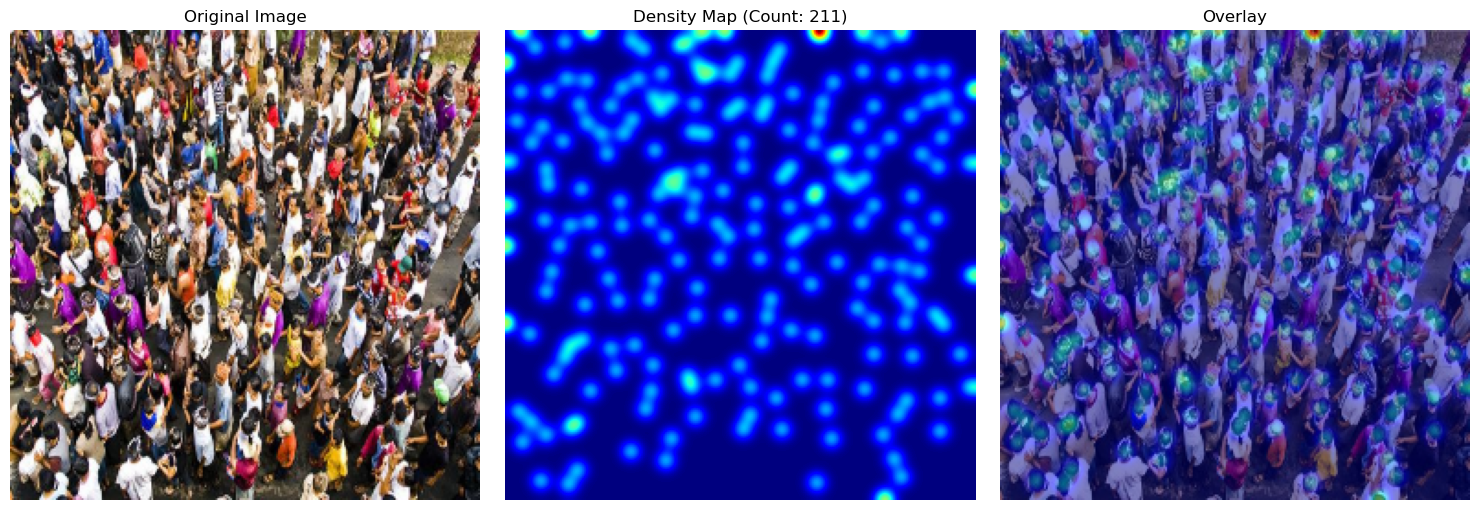

Estimated count: 211.00
Actual count: 211.0


In [17]:
def main():
    print("=" * 60)
    print("ShanghaiTech Dataset Preprocessing Pipeline")
    print("=" * 60)
    
    # Process Part A Training Set
    print("\n[1/2] Processing Part A Training Set...")
    train_stats = process_dataset(
        PART_A_TRAIN_IMAGES,
        PART_A_TRAIN_GT,
        TRAIN_PREPROCESSED_IMAGES,
        TRAIN_PREPROCESSED_DENSITY,
        target_size=TARGET_SIZE,
        normalize=NORMALIZE
    )
    
    # Process Part A Test Set
    print("\n[2/2] Processing Part A Test Set...")
    test_stats = process_dataset(
        PART_A_TEST_IMAGES,
        PART_A_TEST_GT,
        TEST_PREPROCESSED_IMAGES,
        TEST_PREPROCESSED_DENSITY,
        target_size=TARGET_SIZE,
        normalize=NORMALIZE
    )
    
    # Display statistics
    print("\n" + "=" * 60)
    print("PREPROCESSING COMPLETE!")
    print("=" * 60)
    
    print("\n📊 Training Set Statistics:")
    print(f"  Total Images: {train_stats['total_images']}")
    print(f"  Total People: {train_stats['total_people']}")
    print(f"  Average Count: {train_stats['avg_count']:.2f}")
    print(f"  Min Count: {train_stats['min_count']}")
    print(f"  Max Count: {train_stats['max_count']}")
    
    print("\n📊 Test Set Statistics:")
    print(f"  Total Images: {test_stats['total_images']}")
    print(f"  Total People: {test_stats['total_people']}")
    print(f"  Average Count: {test_stats['avg_count']:.2f}")
    print(f"  Min Count: {test_stats['min_count']}")
    print(f"  Max Count: {test_stats['max_count']}")
    
    print(f"\n💾 Preprocessed data saved to: {PREPROCESSED_PATH}")
    
    # Visualize random samples
    print("\n📸 Visualizing Random Samples...")
    train_images = os.listdir(TRAIN_PREPROCESSED_IMAGES)
    if train_images:
        sample_img = random.choice(train_images)
        img_path = os.path.join(TRAIN_PREPROCESSED_IMAGES, sample_img)
        density_path = os.path.join(TRAIN_PREPROCESSED_DENSITY, sample_img)
        
        img = np.load(img_path)
        density = np.load(density_path)
        
        visualize_sample(img_path, density, np.sum(density))

if __name__ == "__main__":
    main()
